# Задание 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.


Предлагаем вам ответить на следующие вопросы:

- На какие метрики вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?
- Данный список вопросов не является обязательным, и вы можете при своём ответе опираться на собственный план.


Требования к ответу

- При выполнении тестового задания необходимо использовать язык программирования Python. 
- В файле обязательно должны быть комментарии к тем действиям, которые вы выполняете с данными. 
- Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [93]:
# Импортирую необходимые для работы библиотеки
import pandas as pd
import urllib.parse
from urllib.parse import urlencode
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from scipy import stats
from scipy.stats import chi2_contingency
import pingouin as pg




In [94]:
# Загружаем датасеты по ссылке на яндекс диске
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# Ссылки на датасеты на яндекс диске
public_key1 = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' # groups
public_key2 = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' # groups_add
public_key3 = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' # active_studs
public_key4 = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' # checks

# Получаем загрузочные ссылки
final_url1 = base_url + urlencode(dict(public_key = public_key1))
final_url2 = base_url + urlencode(dict(public_key = public_key2))
final_url3 = base_url + urlencode(dict(public_key = public_key3))
final_url4 = base_url + urlencode(dict(public_key = public_key4))

response1 = requests.get(final_url1)
response2 = requests.get(final_url2)
response3 = requests.get(final_url3)
response4 = requests.get(final_url4)

download_url1 = response1.json()['href']
download_url2 = response2.json()['href']
download_url3 = response3.json()['href']
download_url4 = response4.json()['href']

# Загружаем файлы в df 
download_response1 = requests.get(download_url1) 
download_response2 = requests.get(download_url2) 
download_response3 = requests.get(download_url3) 
download_response4 = requests.get(download_url4)

groups = pd.read_csv(download_url1, sep = ';') 
groups_add = pd.read_csv(download_url2) 
studs = pd.read_csv(download_url3) 
checks = pd.read_csv(download_url4, sep = ';') 

In [95]:
# Просмотрю содержимое датафреймов
groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [96]:
groups_add.head(5)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [97]:
# Соединяю строки из groups и groups_add в один датафрейм
df_groups=pd.concat([groups, groups_add], ignore_index=True)
df_groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [98]:
# Проверяю датафрейм на наличие пустых значений
df_groups.isna().sum()

id     0
grp    0
dtype: int64

In [99]:
# Проверяю датафрейм на наличие дубликатов (повторений)


In [100]:
# Дубликатов нет
df_groups.duplicated().sum()

0

In [101]:
# Проверяю наличие дубликатов в датафрейме studs
# В датафрейме studs нет дубликатов
studs.duplicated().sum()

0

In [102]:
studs.shape

(8341, 1)

In [103]:
# Смотрю количество уникальных student_id
# Количество строк в датафрейме соответствует количеству уникальных student_id
studs['student_id'].nunique()

8341

In [104]:
# Проверяю наличие дубликатов в датафрейме checks
# В датафрейме checks нет дубликатов
checks.duplicated().sum()

0

In [105]:
checks.shape

(541, 2)

In [106]:
# Смотрю количество уникальных student_id
# Количество строк в датафрейме соответствует количеству уникальных student_id
checks['student_id'].nunique()

541

In [107]:
# Объединяю датафреймы df_groups и checks способом left, чтобы не потерять данные из датафрейма df_groups
groups_and_checks=pd.merge(df_groups, checks, how='left', left_on='id', right_on='student_id')
groups_and_checks

,id,grp,student_id,rev
0,1489,B,NaN,NaN
1,1627,A,1627.0,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN
...,...,...,...,...
74571,200247820,B,NaN,NaN
74572,201032527,B,NaN,NaN
74573,201067612,B,NaN,NaN
74574,201067653,B,NaN,NaN


In [108]:
# Удаляю столбец student_id
groups_and_checks.drop('student_id', axis=1, inplace=True)

In [109]:
groups_and_checks.isna().sum()

id         0
grp        0
rev    74035
dtype: int64

In [110]:
groups_and_checks

,id,grp,rev
0,1489,B,NaN
1,1627,A,990.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN
...,...,...,...
74571,200247820,B,NaN
74572,201032527,B,NaN
74573,201067612,B,NaN
74574,201067653,B,NaN


In [111]:
# Соединяю датафреймы
df=groups_and_checks.merge(studs, how='left', left_on='id', right_on='student_id')
df

,id,grp,rev,student_id
0,1489,B,NaN,NaN
1,1627,A,990.0,1627.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN
...,...,...,...,...
74571,200247820,B,NaN,NaN
74572,201032527,B,NaN,NaN
74573,201067612,B,NaN,NaN
74574,201067653,B,NaN,NaN


In [112]:
# Создаю столбец active, где значение True - пользователь заходил на платформу в день проведения эксперимента,
# False - пользователь не заходил на платформу в день эксперимента
df['active']=df['student_id']>0
df

,id,grp,rev,student_id,active
0,1489,B,NaN,NaN,False
1,1627,A,990.0,1627.0,True
2,1768,B,NaN,NaN,False
3,1783,B,NaN,NaN,False
4,1794,A,NaN,NaN,False
...,...,...,...,...,...
74571,200247820,B,NaN,NaN,False
74572,201032527,B,NaN,NaN,False
74573,201067612,B,NaN,NaN,False
74574,201067653,B,NaN,NaN,False


In [113]:
# Проверяю, нет ли ошибок в данных
# Вижу, что 149 неактивных пользователей совершили покупку. Возможно, это ошибка 
df.query('active==False and rev>0')

,id,grp,rev,student_id,active
39,3185,B,690.0,NaN,False
121,25973,B,690.0,NaN,False
125,26280,B,690.0,NaN,False
223,100645,B,630.0,NaN,False
254,102534,B,580.0,NaN,False
...,...,...,...,...,...
72452,5291900,B,199.0,NaN,False
72753,5331842,B,290.0,NaN,False
73632,5486319,B,199.0,NaN,False
74049,5562806,B,398.0,NaN,False


In [114]:
# По условию задания, нас такие пользователи не интересуют, поэтому удаляем из датафрейма этих пользователей
df = df.drop(df[(df.active==False) & (df.rev > 0)].index)
df

,id,grp,rev,student_id,active
0,1489,B,NaN,NaN,False
1,1627,A,990.0,1627.0,True
2,1768,B,NaN,NaN,False
3,1783,B,NaN,NaN,False
4,1794,A,NaN,NaN,False
...,...,...,...,...,...
74571,200247820,B,NaN,NaN,False
74572,201032527,B,NaN,NaN,False
74573,201067612,B,NaN,NaN,False
74574,201067653,B,NaN,NaN,False


In [115]:
df['rev'].describe()

count     392.000000
mean     1193.352050
std       827.136901
min       199.000000
25%       290.000000
50%       990.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [116]:
df

,id,grp,rev,student_id,active
0,1489,B,NaN,NaN,False
1,1627,A,990.0,1627.0,True
2,1768,B,NaN,NaN,False
3,1783,B,NaN,NaN,False
4,1794,A,NaN,NaN,False
...,...,...,...,...,...
74571,200247820,B,NaN,NaN,False
74572,201032527,B,NaN,NaN,False
74573,201067612,B,NaN,NaN,False
74574,201067653,B,NaN,NaN,False


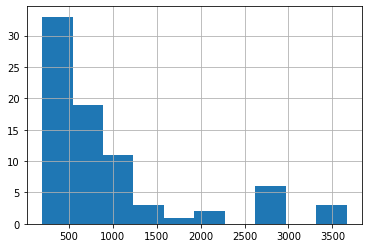

In [117]:
# Строю график распределения дохода от контрольной группы (А)
# Вижу, что распределение НЕнормально
df.query('grp=="A"').rev.hist()

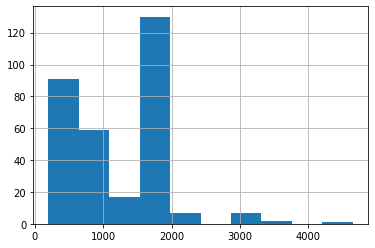

In [118]:
# Строю график распределения дохода от целевой группы (В)
# Вижу, что распределение НЕнормально
df.query('grp=="B"').rev.hist()

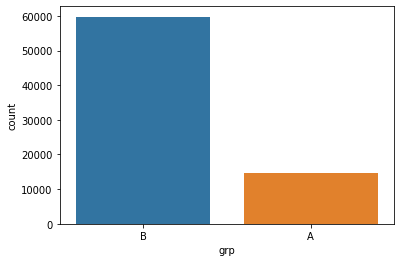

In [119]:
# Строю график и смотрю соотношение количества пользователей в контрольной и целевой группе
# В целевой группе (В) принимало участие гораздо больше пользователей
sns.countplot(data=df, x='grp')

In [120]:
# Считаю количество пользователей в контрольной и целевой группах
df.groupby('grp', as_index=False).id.count()

,grp,id
0,A,14664
1,B,59763


In [121]:
df

,id,grp,rev,student_id,active
0,1489,B,NaN,NaN,False
1,1627,A,990.0,1627.0,True
2,1768,B,NaN,NaN,False
3,1783,B,NaN,NaN,False
4,1794,A,NaN,NaN,False
...,...,...,...,...,...
74571,200247820,B,NaN,NaN,False
74572,201032527,B,NaN,NaN,False
74573,201067612,B,NaN,NaN,False
74574,201067653,B,NaN,NaN,False


У меня есть датафрейм df со следующими данными:
- id  (идентификатор пользователей);
- grp (пользователи поделены на группы A(контрольная) и B(тестовая));
- rev (стоимость оплаты услуг - доход от пользователей в день проведения эксперимента);
- active (информация о том, заходил ли пользователь на платформу в день проведения эксперимента(True - заходил, False - не заходил))

Для того, чтобы провести А/В тест, мне необходимо правильно выбрать метрику, которую я буду оценивать. 

Исходя из имеющихся данных, я считаю правильным выбрать в качестве метрики конверсию из вхождения на платформу в покупку на платформе(кол-во купивших/кол-во зашедших).

Для исследования различий буду использовать критерий хи-квадрат, тк он подходит, если метрика похожа на конверсию.

Нулевая гипотеза (H0): Разницы между конверсией в покупку в тестовой и контрольной группе нет.

Альтернативная гипотеза (H1): Разница между конверсией в покупку в тестовой и контрольной группе есть.

In [122]:
# Считаю количество пользователей, зашедших на платформу в день проведения эксперимента
active_count=df.query('active==True')\
               .groupby('grp', as_index=False)\
               .id.nunique()\
               .rename(columns={'id':'active_count'})
active_count

,grp,active_count
0,A,1538
1,B,6803


In [123]:
# Считаю количество зашедших на платформу и совершивших покупку в день проведения эксперимента
purchase_count=df.query('rev>0 and active==True')\
                 .groupby('grp', as_index=False)\
                 .id.nunique()\
                 .rename(columns={'id':'purchase_count'}) 
purchase_count

,grp,purchase_count
0,A,78
1,B,314


In [124]:
# Объединяю два датафрейма
active_and_purchase=pd.merge(active_count, purchase_count, on='grp')
active_and_purchase

,grp,active_count,purchase_count
0,A,1538,78
1,B,6803,314


In [125]:
# Считаю конверсию в покупку по каждой группе
# Вижу, что конверсия в покупку в тестовой группе ниже, чем в контрольной
active_and_purchase['CR']=active_and_purchase['purchase_count']/active_and_purchase['active_count']
active_and_purchase

,grp,active_count,purchase_count,CR
0,A,1538,78,0.050715
1,B,6803,314,0.046156


In [126]:
active_and_purchase[['active_count', 'purchase_count']]

,active_count,purchase_count
0,1538,78
1,6803,314


In [127]:
# С помощью критерия хи-квадрат считаю уровень значимости

chi2_contingency(active_and_purchase[['active_count', 'purchase_count']])


(0.43612258061018483,
 0.5089998823014525,
 1,
 array([[1543.46226955,   72.53773045],
        [6797.53773045,  319.46226955]]))

Вывод:
pvalue=0.5089998823014525, тк р > 0.05, у нас нет оснований отвергать нулевую гипотезу. 

Соответственно, разница между конверсией в покупку в тестовой и контрольной группе статистически не значима.

При проведении A/B теста так же можно выбрать другую метрику, чтобы оценить новую механику оплаты услуг на сайте. Например, посчитать ARPAU (average revenue by active users) в контрольной и целевой группах и оценить, различаются ли они статистически. Для того, чтобы оценить что-то более "хитрое", чем просто среднее, целесообразно использовать bootstrap.

Нулевая гипотеза: разницы между ARPAU в контрольной и целевой группах нет.
Альтернативная гипотеза:  разница между ARPAU в контрольной и целевой группах есть.

In [128]:
df

,id,grp,rev,student_id,active
0,1489,B,NaN,NaN,False
1,1627,A,990.0,1627.0,True
2,1768,B,NaN,NaN,False
3,1783,B,NaN,NaN,False
4,1794,A,NaN,NaN,False
...,...,...,...,...,...
74571,200247820,B,NaN,NaN,False
74572,201032527,B,NaN,NaN,False
74573,201067612,B,NaN,NaN,False
74574,201067653,B,NaN,NaN,False


In [129]:
# Отбираю только тех пользователей, которые в день проведения эксперимента заходили на сайт
df_active=df.query('active==True')
df_active

,id,grp,rev,student_id,active
1,1627,A,990.0,1627.0,True
10,2085,B,NaN,2085.0,True
12,2215,B,NaN,2215.0,True
43,3391,A,NaN,3391.0,True
45,3401,B,NaN,3401.0,True
...,...,...,...,...,...
74543,5760471,B,NaN,5760471.0,True
74545,5777081,B,NaN,5777081.0,True
74558,5870856,A,NaN,5870856.0,True
74561,5945085,B,NaN,5945085.0,True


In [130]:
# Смотрю средний чек пользователей в группах
df_active.groupby('grp', as_index=False).rev.mean()

,grp,rev
0,A,933.589744
1,B,1257.878992


Средний чек целевой группы на 34% больше, чем у контрольной группы.

In [131]:
# Считаю количество пользователей в контрольной и целевой группах
# (1538+6803=8341б, что соответствует количеству строк в df_active)
df_active.groupby('grp', as_index=False).id.count()

,grp,id
0,A,1538
1,B,6803


In [132]:
# Сохраняю в отдельный датафрейм данные контрольной группы
df_A=df_active.query('grp=="A"')
df_A

,id,grp,rev,student_id,active
1,1627,A,990.0,1627.0,True
43,3391,A,NaN,3391.0,True
331,109623,A,NaN,109623.0,True
614,133678,A,NaN,133678.0,True
1002,175944,A,NaN,175944.0,True
...,...,...,...,...,...
74416,5668989,A,NaN,5668989.0,True
74469,5690284,A,NaN,5690284.0,True
74523,5723133,A,NaN,5723133.0,True
74528,5729371,A,NaN,5729371.0,True


In [133]:
# Сохраняю в отдельный датафрейм данные целевой группы
df_B=df_active.query('grp=="B"')
df_B

,id,grp,rev,student_id,active
10,2085,B,NaN,2085.0,True
12,2215,B,NaN,2215.0,True
45,3401,B,NaN,3401.0,True
112,22994,B,NaN,22994.0,True
159,26899,B,NaN,26899.0,True
...,...,...,...,...,...
74539,5740903,B,1900.0,5740903.0,True
74543,5760471,B,NaN,5760471.0,True
74545,5777081,B,NaN,5777081.0,True
74561,5945085,B,NaN,5945085.0,True


In [134]:
# Повторения буду делать 10 000 раз
mean_diff = []

for i in range(10000):
    sample_data_control = df_A.sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.rev.mean()
    
    
    sample_data_test = df_B.sample(frac=1, replace=True)
    sample_mean_test = sample_data_test.rev.mean()
    
    sample_mean_diff = sample_mean_test - sample_mean_control
    mean_diff.append(sample_mean_diff)

In [135]:
mean_diff

[426.11878778251946,
 280.0620824451412,
 466.252438983051,
 477.75558332914545,
 417.5696322784811,
 185.12403137046,
 238.61445852807537,
 520.7833674980311,
 459.6348899584078,
 263.9655858461538,
 458.98909728589774,
 357.3221472191493,
 173.2031836341264,
 379.0561580782453,
 514.3906390289948,
 432.28933801067103,
 210.3093563315697,
 91.54647884334418,
 397.2749057976081,
 273.1036168168166,
 366.7688531121163,
 254.98345703242853,
 388.2639037037036,
 373.48314140793013,
 394.5826538415438,
 362.68219661202204,
 268.04630648148157,
 224.36316148145193,
 230.762522120433,
 347.38266185308237,
 470.5654502631578,
 334.2321342384198,
 320.92247419918465,
 460.73555834274964,
 304.52474021505384,
 433.8724926825804,
 348.465367267184,
 338.2086027085928,
 456.2560423508469,
 336.3640024968064,
 277.88823199863816,
 347.5223854700856,
 417.9259789122806,
 489.8064433718731,
 342.9135299811902,
 296.0236463459605,
 198.28881980346443,
 350.3634494893495,
 334.82778983507467,
 312.768

In [136]:
# Строю доверительный интервал (верхняя и нижняя граница)
pd.Series(mean_diff).quantile(0.975)

538.9221194005587

In [137]:
pd.Series(mean_diff).quantile(0.025)

101.69846552886553

Доверительный интервал находится в промежутке между 86.015 и 538.619. Данный диапазон не включает в себя 0. Это означает, что разница среднего чека в контрольной и целевой группах статистически значима. Соответственно, у нас есть основание отвергнуть нулевую гипотезу об отсутствии различий ARPAU в контрольной и целевой группах. Делаю вывод, что нужно внедрять новую систему оплаты на сайте на всех пользователей.

# Задание 2. SQL

## 2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

## Важно:
Усердный ученик -  тот, кто решил 20 и больше задач. Но в задании нет информации, можно ли считать студента усердным, если он в сумме по всем предметам решил 20 и более задач, а если посмотрть в разрезе каждого предмета, то он не дотягивает до 20 задач. Я считаю, что усердным учеником можно считать того, кто хотя бы по 1 отдельно взятому предмету решил хотя бы 20 задач.


Поэтому я для начала посчитаю, сколько правильно решенных ответов у каждого студента по каждому предмету, затем с помощью HAVING отфильтрую только те значения, которые больше или равны 20. Этот запрос превращу в подзапрос, из которого посчитаю количество уникальных студентов.


In [138]:
import pandahouse as ph

In [139]:
# Объявляю параметры подключения
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [140]:
# Пишу запрос, и получаю данные из clickhouse в pandas dataframe
query = """
SELECT
COUNT(DISTINCT st_id)
FROM

(
SELECT
st_id,
subject,
SUM(correct) AS correct_answers
FROM default.peas
WHERE correct=1
GROUP BY (st_id, subject)
HAVING SUM(correct)>=20
ORDER BY st_id
) hardworking_students
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,uniqExact(st_id)
0,78


Ответ: 78 усердных учеников, которые хотя бы по 1 дисциплине решили больше 19 задач.

Решила посмотреть и на другой вариант, где усердный ученик - тот, кто в общей сложности по всем дисциплинам решил хотя бы 20 задач. Соответственно, таких учеников больше.

In [141]:
# Пишу запрос, и получаю данные из clickhouse в pandas dataframe
query1 = """
SELECT 
COUNT(distinct st_id)
FROM
(
SELECT 
st_id, 
SUM(correct) AS correct_answers
FROM default.peas 
GROUP BY st_id
HAVING SUM(correct)>=20) t
"""
df1 = ph.read_clickhouse(query1, connection=connection_default)
df1

,uniqExact(st_id)
0,136


Ответ: 136 учеников решили 20 и больше задач в сумме по всем дисциплинам.

## 2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 

- ARPAU 

- CR в покупку

- СR активного пользователя в покупку 

- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике


ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

ARPU=Revenue/Users

ARPAU=Revenue from active users/Active users

CR

In [142]:
# Пишу запрос, и получаю данные из clickhouse в pandas dataframe
query2 = """
WITH active_pilot_users AS (
                            SELECT st_id
                            FROM default.peas AS a LEFT JOIN default.studs AS b USING (st_id)
                            WHERE test_grp='pilot'
                            GROUP BY st_id 
                            HAVING sum(correct)>10
                            ),
     active_control_users AS (
                                 SELECT st_id
                                 FROM default.peas AS a LEFT JOIN default.studs AS b USING (st_id)
                                 WHERE test_grp='control'
                                 GROUP BY st_id 
                                 HAVING sum(correct)>10
     ),
     math_pilot_active_users AS (
                                 SELECT
                                 st_id
                                 FROM default.peas AS a LEFT JOIN default.studs AS b USING(st_id)
                                 WHERE test_grp='pilot' AND subject='Math'
                                 GROUP BY st_id
                                 HAVING sum(correct)>=2
                                ),
    math_control_active_users AS (
                                    SELECT
                                    st_id
                                    FROM default.peas AS a LEFT JOIN default.studs AS b USING (st_id)
                                    WHERE test_grp='control' and subject='Math'
                                    GROUP BY st_id
                                    HAVING sum(correct)>=2
                                  )                            

SELECT  
sumIf(money, test_grp='pilot')/(SELECT count(DISTINCT st_id) FROM default.studs WHERE test_grp='pilot') AS pilot_ARPU,
sumIf(money, test_grp='control')/(SELECT count (DISTINCT st_id) FROM default.studs WHERE test_grp='control') AS control_ARPU,
sumIf(money, st_id IN active_pilot_users)/(SELECT count(Distinct st_id) FROM active_pilot_users) AS pilot_ARPAU,
sumIf(money, st_id IN active_control_users)/(SELECT count(DISTINCT st_id) FROM active_control_users) AS control_ARPAU,
countIf(DISTINCT st_id, test_grp='pilot' and money>0)/(SELECT count(DISTINCT st_id) FROM default.studs WHERE test_grp='pilot'  ) AS pilot_CR,
countIf(DISTINCT st_id, test_grp='control' and money>0)/(SELECT count(DISTINCT st_id) FROM default.studs WHERE test_grp='control') AS control_CR,
countIf(DISTINCT st_id, st_id IN active_pilot_users)/(SELECT count(DISTINCT st_id) FROM active_pilot_users) AS pilot_active_CR,
countIf(DISTINCT st_id, st_id IN active_control_users)/(SELECT count(DISTINCT st_id) FROM active_control_users) AS control_active_CR,
countIf(DISTINCT st_id, st_id IN math_pilot_active_users)/(SELECT count(DISTINCT st_id) FROM math_pilot_active_users) AS math_active_pilot_CR,
countIf(DISTINCT st_id, st_id IN math_control_active_users)/(SELECT count(DISTINCT st_id) FROM math_control_active_users) AS math_active_control_CR



FROM default.final_project_check AS c LEFT JOIN default.studs AS b USING (st_id)
"""
df2 = ph.read_clickhouse(query2, connection=connection_default)
df2

,pilot_ARPU,control_ARPU,pilot_ARPAU,control_ARPAU,pilot_CR,control_CR,pilot_active_CR,control_active_CR,math_active_pilot_CR,math_active_control_CR
0,11508.474576,4540.983607,29739.583333,10393.700787,0.108475,0.04918,0.260417,0.110236,0.142857,0.102041


# Задание 3. Python

## 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [143]:
# Функция, которая автоматически подгружает информацию из файла groups.csv с информацией в файле groups_add.csv
# и сохраняет в отдельный новый файл updated.csv (чтобы не изменять данные в groups.csv)
# и выводит таблицу с метрикой

def update(groups_file, additional_file):
    # Загрузка данных из файлов 
    groups_data = pd.read_csv(groups_file, sep=';')
    additional_data = pd.read_csv(additional_file)

    # Объединение данных
    updated_groups_data = pd.concat([groups_data, additional_data], ignore_index=True)
    
        # Загрузка данных 
    studs_data=pd.read_csv('Проект_2_active_studs.csv').rename(columns={'student_id':'id'})
    checks_data=pd.read_csv('Проект_2_checks.csv', sep=';').rename(columns={'student_id':'id'})
    
    # Объединение данных
    updated_studs_data=pd.merge(updated_groups_data, studs_data, how='left', on='id')
    full_data=pd.merge(updated_studs_data, checks_data, how='left', on='id')
    
    # Создаю метрику
    rev_metric=full_data.groupby('grp', as_index=False).rev.sum()
    users_metric=full_data.groupby('grp', as_index=False).id.nunique()
    metric=pd.merge(rev_metric, users_metric, on='grp')
    metric['ARPU']=metric['rev']/metric['id']
    
     
    # Сохранение обновленных данных в новый файл updated.csv
    updated_groups_data.to_csv('updated.csv', index=False)
    
    return metric
metric=update('Проект_2_groups.csv', 'Проект_2_group_add.csv')



In [144]:
metric

,grp,rev,id,ARPU
0,A,92096.0000,14693,6.268019
1,B,481230.0036,59883,8.036171


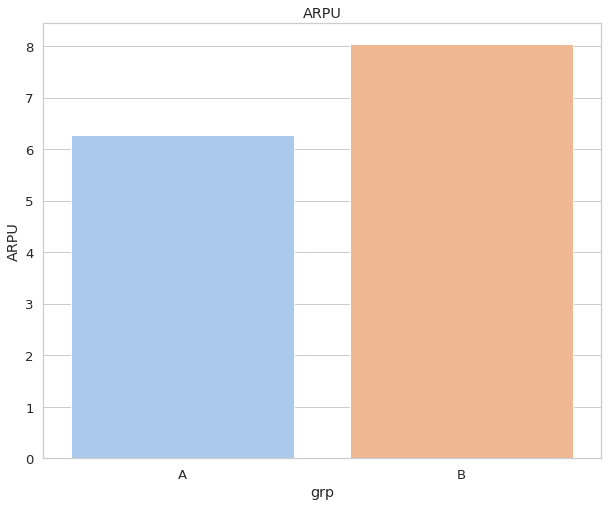

In [145]:
# Функция, которая строит график по рассчитанной выше метрике
def plot_metric(metric):
    sns.set(font_scale=1.2, style="whitegrid", rc={'figure.figsize': (10, 8)})
    plt.title('ARPU')
    sns.barplot(data=metric, x='grp', y='ARPU', palette='pastel')

plot_metric(metric)